<div style="text-align:center"><span style="font-size:3em;">Capstone Project</span></div>


<div style="text-align:center"><span style="font-size:2em;"> Where is the best place to open a new GYM in Vienna </span></div>



We are going to analyse the following data:

1- Gographic data represent Vienna city and the metro stations. 

2- The numbers of GYM centers next to the metro stations. 

Based on the previous data, we are going to suggest the best locations to open new GYM centers. 

In [81]:
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge folium --yes


from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import pandas as pd
# Set pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', -1)

from pandas.io.json import json_normalize

import folium # map rendering library

import requests

import numpy as np

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn import metrics

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.pyplot import subplots

from sklearn import preprocessing

print('Libraries imported.')

Libraries imported.


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  import sys


# Data Acquisition, Cleaning and Transformation¶


Get the geospatial coordinates of 'Syntagma Square'

In [10]:
address = 'Schwedenplatz, Austria'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Schwedenplatz Metro Station are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Schwedenplatz Metro Station are 48.2117909, 16.3776525.


In [11]:
string = str(latitude) + ', ' +str(longitude)
address = geolocator.reverse(string, language='en')
address

Location(Schwedenplatz, Franz-Josefs-Kai, Seitenstettnerhof, KG Innere Stadt, Innere Stadt, Vienna, 1010, Austria, (48.2117909, 16.3776525, 0.0))

In [12]:
map_syntagma = folium.Map(location=[latitude, longitude], zoom_start=18)
folium.Marker([latitude, longitude], popup='Syntagma Square').add_to(map_syntagma)
map_syntagma

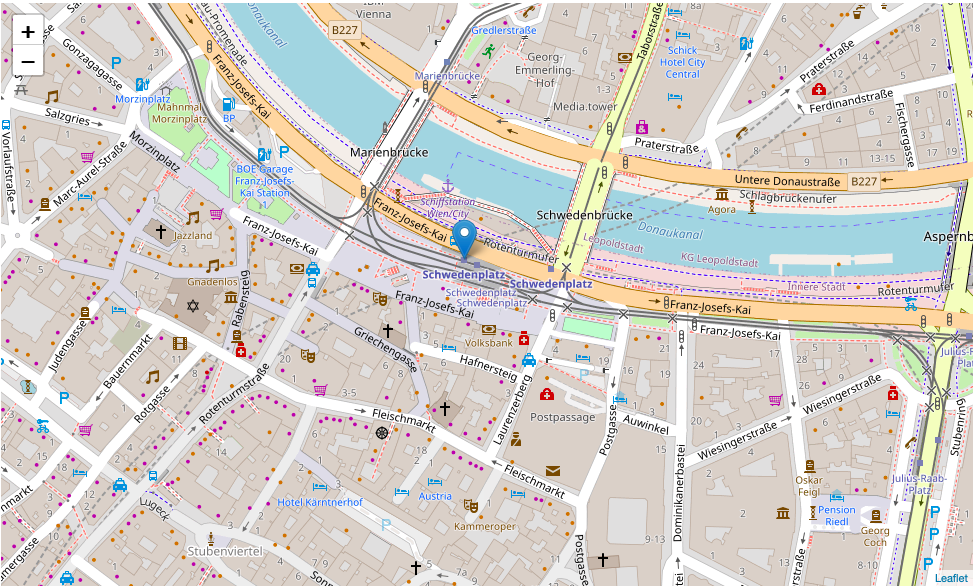

In [29]:
CLIENT_ID = 'YONVAXFGFANYEE4EL30B0HCYKLPE0FT4KHX0BR3WWHZPRB4D' # your Foursquare ID
CLIENT_SECRET = '3HJHECNXW32ZWRG21P1HBBNPTVWP0TFDKF3AVLFNBMYU45G0' # your Foursquare Secret

Get the metro stations in Athens in radius of 15 km around Schwedenplatz


In [30]:
radius = 15000
VERSION = '20190630' # Foursquare API version
LIMIT = 200
category_id = '4bf58dd8d48988d1fd931735' # Metro Stations

In [31]:
url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    category_id,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude,
    longitude, 
    radius,
    LIMIT
)

In [32]:
# stations_list = results['response']['groups'][0]['items']
stations_list = requests.get(url).json()['response']['groups'][0]['items']
stations_init_df = json_normalize(stations_list)

stations_init_df.head(2)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.crossStreet,venue.location.neighborhood
0,e-0-4b5ffa01f964a5203cd229e3-0,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",4b5ffa01f964a5203cd229e3,S+U Spittelau,Spittelauer Lände,48.235659,16.358119,"[{'label': 'display', 'lat': 48.23565860432231, 'lng': 16.358119231877172}]",3026,1090,AT,Wien,Wien,Österreich,"[Spittelauer Lände, 1090 Wien, Österreich]","[{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}]",0,[],NaN,NaN
1,e-0-4c7a66b283a7bfb7f87b83f8-1,0,"[{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]",4c7a66b283a7bfb7f87b83f8,U Stadtpark,Stadtpark,48.202996,16.379414,"[{'label': 'display', 'lat': 48.20299631747138, 'lng': 16.379413604736328}]",987,1030,AT,Wien,Wien,Österreich,"[Stadtpark, 1030 Wien, Österreich]","[{'id': '4bf58dd8d48988d1fd931735', 'name': 'Metro Station', 'pluralName': 'Metro Stations', 'shortName': 'Metro', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/subway_', 'suffix': '.png'}, 'primary': True}]",0,[],NaN,NaN


Extract station information

In [34]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.distance', 'venue.location.postalCode']
stations_filtered_df = stations_init_df.loc[:, filtered_columns]

# filter the category for each row
stations_filtered_df['venue_type'] = stations_init_df['venue.categories'].apply(lambda x: dict(x[0])['name'])

# clean columns
stations_filtered_df.columns = [col.split('.')[-1] for col in stations_filtered_df.columns]

stations_df = stations_filtered_df[stations_filtered_df['venue_type'] == 'Metro Station']
stations_df = stations_df.drop('categories', axis=1)
stations_df.head()


,name,lat,lng,distance,postalCode,venue_type
0,S+U Spittelau,48.235659,16.358119,3026,1090,Metro Station
1,U Stadtpark,48.202996,16.379414,987,1030,Metro Station
2,U Schwedenplatz,48.211734,16.377134,39,1010,Metro Station
3,U Stubentor,48.207765,16.378657,454,1010,Metro Station
4,U Stephansplatz,48.208161,16.371580,605,1010,Metro Station


In [35]:
stations_df.rename(columns={'name': 'station',
                            'distance': 'Distance from Center',
                            'postalCode': 'Postal Code',
                            'venue_type': 'Venue Type'},
                   inplace=True)

stations_df.reset_index(drop=True, inplace=True)

print(stations_df.info())
stations_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   station               95 non-null     object 
 1   lat                   95 non-null     float64
 2   lng                   95 non-null     float64
 3   Distance from Center  95 non-null     int64  
 4   Postal Code           78 non-null     object 
 5   Venue Type            95 non-null     object 
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ KB
None


,station,lat,lng,Distance from Center,Postal Code,Venue Type
0,S+U Spittelau,48.235659,16.358119,3026,1090,Metro Station
1,U Stadtpark,48.202996,16.379414,987,1030,Metro Station
2,U Schwedenplatz,48.211734,16.377134,39,1010,Metro Station
3,U Stubentor,48.207765,16.378657,454,1010,Metro Station
4,U Stephansplatz,48.208161,16.371580,605,1010,Metro Station


Visualize the metro stations on a map of Vienna

In [41]:
# create map of Vienna using latitude and longitude values
map_Vienna = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, station in zip(stations_df['lat'],
                          stations_df['lng'],
                          stations_df['station']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False
    ).add_to(map_Vienna)
    
map_Vienna

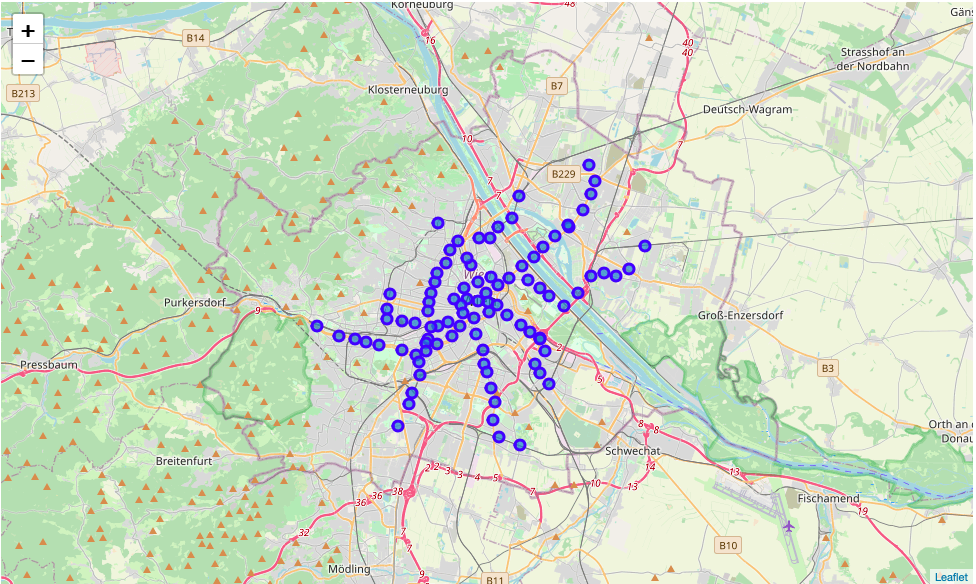

Get the gyms near the stations
Category id for metro stations: 4bf58dd8d48988d175941735
Source: https://developer.foursquare.com/docs/resources/categories
Function to create a dataframe with the results gathered from Foursquare API on a specific category

In [42]:
def getNearbyGyms(categoryId, stations, latitudes, longitudes, radius=750):
    
    print('Findind gyms near Schwedenplatz metro stations, please wait...\n')
    
    gyms_list=[]
    for station, lat, lng in zip(stations, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            categoryId,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby gym
        gyms_list.append([(
            station,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']
        ) for v in results])

    nearby_gyms_df = pd.DataFrame([item for venue_list in gyms_list for item in venue_list])
    nearby_gyms_df.columns = [
                  'station',
                  'lat',
                  'lng',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Distance from Station',
                  'Venue Category']
    print('Finished')
    return(nearby_gyms_df)

Use the function to gather information about existing gyms in a radius of 750m around each metro station in Vienna


In [43]:
categoryId = '4bf58dd8d48988d175941735' # Gym / Fitness Center
gyms_venues_df = getNearbyGyms(categoryId, stations=stations_df['station'], latitudes=stations_df['lat'], longitudes=stations_df['lng'])

Findind gyms near Schwedenplatz metro stations, please wait...

Finished


In [44]:
gyms_venues_df.head()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station,Venue Category
0,S+U Spittelau,48.235659,16.358119,Manhattan Fitness (Nord),48.239252,16.361843,485,Gym
1,S+U Spittelau,48.235659,16.358119,Eurogym Döbling,48.233808,16.352828,443,Gym / Fitness Center
2,S+U Spittelau,48.235659,16.358119,CrossZone Döbling,48.234819,16.355535,213,Gym / Fitness Center
3,S+U Spittelau,48.235659,16.358119,Sportunion Döbling,48.232837,16.354071,434,Gym / Fitness Center
4,S+U Spittelau,48.235659,16.358119,Fit Fabrik Plus,48.234135,16.352094,477,Gym / Fitness Center


Let's check the categories of venues that were returned for each neighborhood


In [45]:
gyms_venues_df.groupby(['Venue Category']).count()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station
Venue Category,,,,,,,
Athletics & Sports,3,3,3,3,3,3,3
Climbing Gym,15,15,15,15,15,15,15
Doctor's Office,2,2,2,2,2,2,2
Gym,151,151,151,151,151,151,151
Gym / Fitness Center,207,207,207,207,207,207,207
Gym Pool,10,10,10,10,10,10,10
Gymnastics Gym,2,2,2,2,2,2,2
Martial Arts Dojo,50,50,50,50,50,50,50
Pilates Studio,1,1,1,1,1,1,1


We will only keep the two categories [Gym, Gym / Fitness Center]


In [46]:
gyms_venues_df = gyms_venues_df[gyms_venues_df['Venue Category'].isin(['Gym', 'Gym / Fitness Center'])]
gyms_venues_df.head()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station,Venue Category
0,S+U Spittelau,48.235659,16.358119,Manhattan Fitness (Nord),48.239252,16.361843,485,Gym
1,S+U Spittelau,48.235659,16.358119,Eurogym Döbling,48.233808,16.352828,443,Gym / Fitness Center
2,S+U Spittelau,48.235659,16.358119,CrossZone Döbling,48.234819,16.355535,213,Gym / Fitness Center
3,S+U Spittelau,48.235659,16.358119,Sportunion Döbling,48.232837,16.354071,434,Gym / Fitness Center
4,S+U Spittelau,48.235659,16.358119,Fit Fabrik Plus,48.234135,16.352094,477,Gym / Fitness Center


Make sure that the not needed venues were removed


In [47]:
gyms_venues_df.groupby(['Venue Category']).count().head(10)

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station
Venue Category,,,,,,,
Gym,151,151,151,151,151,151,151
Gym / Fitness Center,207,207,207,207,207,207,207



Add distance from each metro station to the nearest gym and number of existing gyms in its vicinity
Add to the data frame the minimum distance of every station to the gyms in its vicinity

In [49]:
gyms_venues_min_df = pd.merge(gyms_venues_df,
                              pd.DataFrame(gyms_venues_df.groupby('station')['Distance from Station'].min()),
                              on='station', how='inner')

gyms_venues_min_df.head()


,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station_x,Venue Category,Distance from Station_y
0,S+U Spittelau,48.235659,16.358119,Manhattan Fitness (Nord),48.239252,16.361843,485,Gym,213
1,S+U Spittelau,48.235659,16.358119,Eurogym Döbling,48.233808,16.352828,443,Gym / Fitness Center,213
2,S+U Spittelau,48.235659,16.358119,CrossZone Döbling,48.234819,16.355535,213,Gym / Fitness Center,213
3,S+U Spittelau,48.235659,16.358119,Sportunion Döbling,48.232837,16.354071,434,Gym / Fitness Center,213
4,S+U Spittelau,48.235659,16.358119,Fit Fabrik Plus,48.234135,16.352094,477,Gym / Fitness Center,213


Add the number of already existing gyms in the vicinity of each station


In [50]:
gyms_venues_min_count_df = pd.merge(gyms_venues_min_df,
                           pd.DataFrame(gyms_venues_min_df.groupby(['station']).count())['lat'],
                           on='station', how='inner')

gyms_venues_min_count_df.head()

,station,lat_x,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station_x,Venue Category,Distance from Station_y,lat_y
0,S+U Spittelau,48.235659,16.358119,Manhattan Fitness (Nord),48.239252,16.361843,485,Gym,213,7
1,S+U Spittelau,48.235659,16.358119,Eurogym Döbling,48.233808,16.352828,443,Gym / Fitness Center,213,7
2,S+U Spittelau,48.235659,16.358119,CrossZone Döbling,48.234819,16.355535,213,Gym / Fitness Center,213,7
3,S+U Spittelau,48.235659,16.358119,Sportunion Döbling,48.232837,16.354071,434,Gym / Fitness Center,213,7
4,S+U Spittelau,48.235659,16.358119,Fit Fabrik Plus,48.234135,16.352094,477,Gym / Fitness Center,213,7


Give appropriate names to the dataframe columns

In [52]:
gyms_df = gyms_venues_min_count_df.rename(columns={'lat_x': 'lat', 'Distance from Station_x': 'Distance from Station',
                                                   'Distance from Station_y': 'Min Distance from Station',
                                                   'lat_y': 'Gym Count'})
gyms_df.head()

,station,lat,lng,Venue,Venue Latitude,Venue Longitude,Distance from Station,Venue Category,Min Distance from Station,Gym Count
0,S+U Spittelau,48.235659,16.358119,Manhattan Fitness (Nord),48.239252,16.361843,485,Gym,213,7
1,S+U Spittelau,48.235659,16.358119,Eurogym Döbling,48.233808,16.352828,443,Gym / Fitness Center,213,7
2,S+U Spittelau,48.235659,16.358119,CrossZone Döbling,48.234819,16.355535,213,Gym / Fitness Center,213,7
3,S+U Spittelau,48.235659,16.358119,Sportunion Döbling,48.232837,16.354071,434,Gym / Fitness Center,213,7
4,S+U Spittelau,48.235659,16.358119,Fit Fabrik Plus,48.234135,16.352094,477,Gym / Fitness Center,213,7


In [57]:
gyms_df = gyms_df[['station', 'lat', 'lng', 'Min Distance from Station', 'Gym Count']].drop_duplicates()
gyms_df.head()

,station,lat,lng,Min Distance from Station,Gym Count
0,S+U Spittelau,48.235659,16.358119,213,7
7,U Stadtpark,48.202996,16.379414,110,9
16,U Schwedenplatz,48.211734,16.377134,320,6
22,U Stubentor,48.207765,16.378657,178,9
31,U Stephansplatz,48.208161,16.371580,353,7


In [55]:
gyms_df.shape

(87, 5)

We will merge the initial stations_df dataframe with the previously created gyms_df and assign 10000 to 'Min Distance from Station' and 0 to 'Gym Count'


In [58]:
missing_stations_df = pd.merge(stations_df[['station', 'lat', 'lng']], gyms_df,
                                    on='station', how='left')
missing_stations_df[missing_stations_df['Gym Count'].isnull()]

,station,lat_x,lng_x,lat_y,lng_y,Min Distance from Station,Gym Count
33,U Gumpendorfer Straße,48.190753,16.337528,NaN,NaN,NaN,NaN
47,U Margaretengürtel,48.188427,16.343230,NaN,NaN,NaN,NaN
52,U Neue Donau,48.246224,16.395010,NaN,NaN,NaN,NaN
56,U Zippererstraße,48.179483,16.411085,NaN,NaN,NaN,NaN
59,U Donaustadtbrücke,48.212075,16.440018,NaN,NaN,NaN,NaN
77,U Hietzing,48.187971,16.303592,NaN,NaN,NaN,NaN
92,U Großfeldsiedlung,48.270519,16.447977,NaN,NaN,NaN,NaN
93,U Hausfeldstraße,48.233366,16.486565,NaN,NaN,NaN,NaN


Now is a good time to make a copy of the dataframe that was created


In [59]:
stations_gyms_grouped_df = gyms_df.copy()

In [60]:
stations_gyms_grouped_df.head()

,station,lat,lng,Min Distance from Station,Gym Count
0,S+U Spittelau,48.235659,16.358119,213,7
7,U Stadtpark,48.202996,16.379414,110,9
16,U Schwedenplatz,48.211734,16.377134,320,6
22,U Stubentor,48.207765,16.378657,178,9
31,U Stephansplatz,48.208161,16.371580,353,7


# Normalize Data [Min Distance from Station, Gym Count]


Data Standardization give data zero mean and unit variance

In [62]:
print('All stations mean distance from any gym: ', stations_gyms_grouped_df['Min Distance from Station'].mean())
print('All stations maximum distance from any gym: ',stations_gyms_grouped_df['Min Distance from Station'].max())
print('All stations minimum distance from any gym: ', stations_gyms_grouped_df['Min Distance from Station'].min())
print('All stations mean of number of existing gyms: ', stations_gyms_grouped_df['Gym Count'].mean())
print('All stations maximum number of existing gyms: ', stations_gyms_grouped_df['Gym Count'].max())
print('All stations minimum number of existing gyms: ', stations_gyms_grouped_df['Gym Count'].min())

All stations mean distance from any gym:  264.2413793103448
All stations maximum distance from any gym:  711
All stations minimum distance from any gym:  21
All stations mean of number of existing gyms:  4.114942528735632
All stations maximum number of existing gyms:  10
All stations minimum number of existing gyms:  1


In [63]:
stations_gyms_grouped_df['Norm Min Distance from Station'] = (stations_gyms_grouped_df['Min Distance from Station'] - \
                                                              stations_gyms_grouped_df['Min Distance from Station'].mean()) / \
                                                             (stations_gyms_grouped_df['Min Distance from Station'].max() - \
                                                              stations_gyms_grouped_df['Min Distance from Station'].min())
stations_gyms_grouped_df['Norm Gym Count'] = (stations_gyms_grouped_df['Gym Count'] - stations_gyms_grouped_df['Gym Count'].mean()) / \
                                             (stations_gyms_grouped_df['Gym Count'].max() - stations_gyms_grouped_df['Gym Count'].min())

In [64]:
stations_gyms_grouped_df['Gym Count'] = stations_gyms_grouped_df['Gym Count'].astype(int)


In [65]:
stations_gyms_grouped_df.reset_index(drop=True, inplace=True)


In [66]:
stations_gyms_grouped_df.head(10)


,station,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
0,S+U Spittelau,48.235659,16.358119,213,7,-0.074263,0.320562
1,U Stadtpark,48.202996,16.379414,110,9,-0.223538,0.542784
2,U Schwedenplatz,48.211734,16.377134,320,6,0.080810,0.209451
3,U Stubentor,48.207765,16.378657,178,9,-0.124988,0.542784
4,U Stephansplatz,48.208161,16.371580,353,7,0.128636,0.320562
5,U Nestroyplatz,48.215351,16.385593,166,5,-0.142379,0.098340
6,U Schottenring,48.216977,16.371399,174,9,-0.130785,0.542784
7,U Landstraße,48.206148,16.384542,84,9,-0.261219,0.542784
8,U Taborstraße,48.219025,16.380771,516,5,0.364868,0.098340
9,U Karlsplatz,48.200345,16.368817,320,5,0.080810,0.098340


In [67]:
gyms_clustering_df = stations_gyms_grouped_df.drop(['station', 'lat', 'lng', 'Min Distance from Station', 'Gym Count'], 1)


In [68]:
gyms_clustering_df.head()


,Norm Min Distance from Station,Norm Gym Count
0,-0.074263,0.320562
1,-0.223538,0.542784
2,0.080810,0.209451
3,-0.124988,0.542784
4,0.128636,0.320562


# K-Means Clustering

Prepare the dataframe to be used in K-Means algorithm¶


Use the Elbow method to find the best k for clustering¶


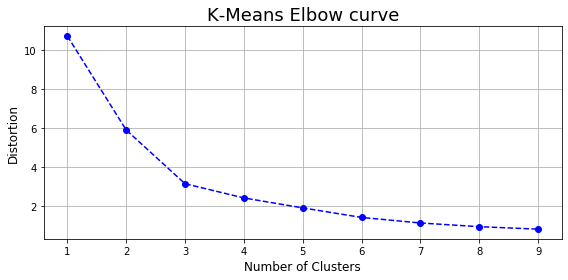

In [69]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

distorsions = []
for k in range(1, 10):
    kmeans = KMeans(init="k-means++", n_clusters=k, random_state=0, n_init = 12, max_iter=300, tol=0.00001)
    kmeans.fit(gyms_clustering_df)
    distorsions.append(kmeans.inertia_)

fig, ax = subplots(figsize=(8, 4))
ax.plot(range(1, 10), distorsions, '--bo')
ax.set_xlabel('Number of Clusters', fontsize=12)
ax.set_ylabel('Distortion', fontsize=12)
plt.grid(True)
plt.title('K-Means Elbow curve', fontsize='18')
plt.tight_layout()
plt.show()

The elbow graph, although not very steep, presents an elbow point at 3 number of clusters.


Run k-means to cluster the station areas to 3 clusters¶



In [70]:
# venues_grouped_clustering_df = venues_grouped_df.drop('station', 1)
kmeans = KMeans(init="k-means++", n_clusters=3, random_state=0, n_init = 12, max_iter=300, tol=0.0001)
kmeans.fit(gyms_clustering_df)

kmeans.labels_

array([2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 2, 2, 0, 1, 2, 0, 0, 0, 0, 2, 1, 2,
       0, 0, 2, 0, 1, 1, 1, 0, 0, 1, 0, 0, 2, 0, 0, 1, 2, 1, 2, 0, 2, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)


# K-Means Clustering Results


Create a new dataframe that includes the resulted clusters and relevant metro station information


In [71]:
# add clustering labels
stations_gyms_grouped_df.insert(1, 'Cluster Label', kmeans.labels_)


In [72]:
stations_gyms_grouped_df.head()


,station,Cluster Label,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
0,S+U Spittelau,2,48.235659,16.358119,213,7,-0.074263,0.320562
1,U Stadtpark,2,48.202996,16.379414,110,9,-0.223538,0.542784
2,U Schwedenplatz,2,48.211734,16.377134,320,6,0.080810,0.209451
3,U Stubentor,2,48.207765,16.378657,178,9,-0.124988,0.542784
4,U Stephansplatz,2,48.208161,16.371580,353,7,0.128636,0.320562


Visualize the metro stations clusters on a map of Vienna


In [73]:
cluster_colors = ['orange', 'red', 'blue'] #, 'green', 'purple', 'pink', 'purple', 'lightblue', 'yellow']

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

markers_colors = []
for lat, lon, poi, cluster in zip(stations_gyms_grouped_df['lat'], stations_gyms_grouped_df['lng'], 
                                  stations_gyms_grouped_df['station'], stations_gyms_grouped_df['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster + 1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cluster_colors[cluster],
        fill=True,
        fill_color=cluster_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Now visualize the (normalized) clusters distribution on a scatter plot along with their final corresponding centroids


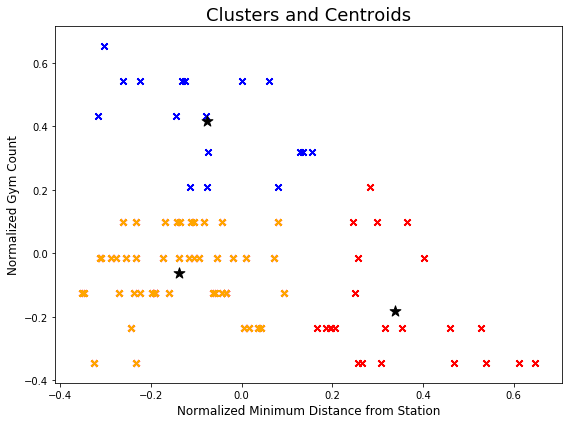

In [74]:
fig, ax = subplots(figsize=(8, 6))
for label in kmeans.labels_:
    plt.scatter(stations_gyms_grouped_df[stations_gyms_grouped_df['Cluster Label'] == label]['Norm Min Distance from Station'],
                stations_gyms_grouped_df[stations_gyms_grouped_df['Cluster Label'] == label]['Norm Gym Count'],
                marker='x', color=cluster_colors[label])
for centroid in kmeans.cluster_centers_:
#     print(centroid)
    plt.scatter(centroid[0], centroid[1], s=130, marker="*", color='black')
ax.set_xlabel('Normalized Minimum Distance from Station', fontsize=12)
ax.set_ylabel('Normalized Gym Count', fontsize=12)
plt.title('Clusters and Centroids', fontsize='18')
plt.tight_layout()
plt.show()

Show the Metro stations that correspond to each cluster¶


Cluster 1 (AVERAGE potential)


Although not a prohibitive metro station to open a gym in its vicinity, there is already a fair number of gyms in the area and the nearest one is not far from the metro station


In [75]:
stations_gyms_grouped_df.loc[stations_gyms_grouped_df['Cluster Label'] == 0]


,station,Cluster Label,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
5,U Nestroyplatz,0,48.215351,16.385593,166,5,-0.142379,0.098340
9,U Karlsplatz,0,48.200345,16.368817,320,5,0.080810,0.098340
12,U Praterstern,0,48.218758,16.392772,227,4,-0.053973,-0.012771
15,U Museumsquartier,0,48.202578,16.361388,192,5,-0.104698,0.098340
16,U Roßauer Lände,0,48.224683,16.366736,289,2,0.035882,-0.234994
17,U Rathaus,0,48.209276,16.355202,207,5,-0.082959,0.098340
18,U Friedensbrücke,0,48.227733,16.364228,104,4,-0.232234,-0.012771
22,U Vorgartenstraße,0,48.224242,16.401785,187,5,-0.111944,0.098340
23,U Kardinal-Nagl-Platz,0,48.197226,16.400939,313,4,0.070665,-0.012771
25,U Kaisermühlen - VIC,0,48.232855,16.416253,221,3,-0.062669,-0.123883


Cluster 2 (LOW potential])¶


There are already many existing gyms in the area and the nearest gym is in most cases in a relatively short distance from the station


In [76]:
stations_gyms_grouped_df.loc[stations_gyms_grouped_df['Cluster Label'] == 1]


,station,Cluster Label,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
8,U Taborstraße,1,48.219025,16.380771,516,5,0.364868,0.098340
13,U Volkstheater,1,48.206581,16.360202,434,5,0.246027,0.098340
20,U Taubstummengasse,1,48.192951,16.370230,441,1,0.256172,-0.346105
26,U Währinger Straße - Volksoper,1,48.225589,16.349512,476,1,0.306897,-0.346105
27,U Alser Straße,1,48.216721,16.341894,636,1,0.538781,-0.346105
28,U Michelbeuern-AKH,1,48.221124,16.343837,582,2,0.460520,-0.234994
31,U Dresdner Straße,1,48.237137,16.379929,470,5,0.298201,0.098340
37,U Thaliastraße,1,48.207866,16.338073,460,6,0.283708,0.209451
39,U Donauinsel,1,48.228532,16.410356,442,4,0.257621,-0.012771
47,U Donaumarina,1,48.205868,16.430992,379,2,0.166317,-0.234994


Cluster 3 (HIGH potential)


There are not many already existing gyms in the area and the nearest gym is in most cases relatively not in a short distance to the metro station


In [77]:
stations_gyms_grouped_df.loc[stations_gyms_grouped_df['Cluster Label'] == 2]


,station,Cluster Label,lat,lng,Min Distance from Station,Gym Count,Norm Min Distance from Station,Norm Gym Count
0,S+U Spittelau,2,48.235659,16.358119,213,7,-0.074263,0.320562
1,U Stadtpark,2,48.202996,16.379414,110,9,-0.223538,0.542784
2,U Schwedenplatz,2,48.211734,16.377134,320,6,0.080810,0.209451
3,U Stubentor,2,48.207765,16.378657,178,9,-0.124988,0.542784
4,U Stephansplatz,2,48.208161,16.371580,353,7,0.128636,0.320562
6,U Schottenring,2,48.216977,16.371399,174,9,-0.130785,0.542784
7,U Landstraße,2,48.206148,16.384542,84,9,-0.261219,0.542784
10,U Herrengasse,2,48.209233,16.364342,358,7,0.135882,0.320562
11,U Schottentor,2,48.214076,16.361867,264,9,-0.000350,0.542784
14,U Rochusgasse,2,48.201766,16.391423,164,8,-0.145277,0.431673


# Discussion


The previous data present which stations got high number of GYM centers within a distance of 750 m. 

We had three catigoried of stations based on the number of GYM centers in the surroundings.  

Few stations got no centers in the neighborhood, which make them ideal to open a new center next to them, but we should bare in mind that there are many other important information to check before taking such a decision like the population, Age groups, gender, income, other sport centers, etc.